This jupyter notebook helps us to analyse the *quality* of the beads for one experiment.  
We can analyse either one single track or a dictionary of tracks. 

In this jupyter notebook, the *quality* is related to the qualification of the bead defined by the criteria defined in `cleaning`. 

# Import the modules

Loading BokehJS ...


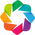

INFO:depixus.:cycles_v4.11.3-37-g5230a3fa+ for jupyter
INFO:depixus.:Beginners can start by typing: tutorial()


In [1]:
#import scripting
import sys
sys.path.insert(0, "../build")
from scripting import *

In [2]:
from IPython.display import Markdown
from cleaning.datacleaning import DataCleaning
Markdown('\n'.join(i[4:] for i in DataCleaning.__doc__.split('\n')))


Remove specific points, cycles or even the whole bead depending on a number
of criteria implemented in aptly named methods:

# `aberrant`

Removes aberrant values.

A value at position *n* is aberrant if any:

* |z[n] - median(z)| > maxabsvalue
* |(z[n+1]-z[n-1])/2-z[n]| > maxderivate
* |z[I-mindeltarange+1] - z[I-mindeltarange+2] | < mindeltavalue
  && ...
  && |z[I-mindeltarange+1] - z[I]|               < mindeltavalue
  && n ∈ [I-mindeltarange+2, I]
* #{z[I-nanwindow//2:I+nanwindow//2] is nan} < nanratio*nanwindow



# `hfsigma`

Remove cycles with too low or too high a variability.

The variability is measured as the median of the absolute value of the
pointwise derivate of the signal. The median itself is estimated using the
P² quantile estimator algorithm.

Too low a variability is a sign that the tracking algorithm has failed to
compute a new value and resorted to using a previous one.

Too high a variability is likely due to high brownian motion amplified by a
rocking motion of a bead due to the combination of 2 factors:

1. The bead has a prefered magnetisation axis. This creates a prefered
horisontal plane and thus a prefered vertical axis.
2. The hairpin is attached off-center from the vertical axis of the bead.


# `population`

Remove cycles with too few good points.

Good points are ones which have not been declared aberrant and which have
a finite value.


# `extent`

Remove cycles which don't open.

That the bead hasn't opened is extracted directly from too low a z range between
the phases `PHASE.initial` and `PHASE.pull`.


# `saturation`

Remove beads which don't have enough cycles ending at zero.

When too many cycles (> 90%) never reach 0 before the end of phase 5, the bead is
discarded. Such a case arises when:

* the hairpin never closes: the force is too high,
* a hairpin structure keeps the hairpin from closing. Such structures should be
detectable in ramp files.
* an oligo is blocking the loop.

# `pseudo code cleaning`
Beads(trk) = set of all beads of the track trk <br>
Cycles(bd) = set of all cycles in bead bd <br>
Points(cy) = set of all points in cycle cy <br>
<br>
For a track trk, cleaning proceeds as follows:
* for bd in Beads(trk):
    * for cy in Cycles(bd):
        * evaluate criteria for cy:
            1. extent < 0.5
            2. hfsigma < 0.0001
            3. hfsigma > 0.01
            4. population (not aberrant Points(cy)/Points(cy)) > 80%
        * if 1. or 2. or 3. or 4. are FALSE:
            * remove cy from Cycles(bd)
        * else:
            * keep cy in Cycles(bd)
    * endfor
    * evaluate criteria for bd:
        5. population (Cycles(bd)/initial Cycles(bd)) > 80%
        6. saturation (Cycles(bd)) < 90%
    * if 5. or 6. are FALSE:
        * bd is bad
    *else:
        * bd is good
    *endif
 *endfor
    * else
        * other
    *endif
* endfor


# Loading the data

We can load a single track or a dictionary

## Load single track

In [3]:
#Load the track, put the path of the track file
#track = Track("/media/sandra/sirius/Andreas/ssHP6_Sequencing_20171220/AGC_1nM/Test_022_043_AGC_1nM_OR3_20nM_ssHP6_FOV1.trk") #, match=".*_043_(\w\w\w)_.*")
track = Track("../../Documents/local_test_data/tests/ssHP6_Sequencing_20171220/AGC_3nM/Test_022_043_AGC_3nM_OR3_20nM_ssHP6_FOV1.trk")
#track = Track("/media/sandra/sirius/Andreas/ssHP6_Sequencing_20171220/AGC_1nM/Test_022_043_AGC_1nM_OR3_20nM_ssHP6_FOV1.trk")

We define a name for `track`

In [4]:
track.key = 'AGC'

## Load dictionary

In [5]:
#Load the tracks, put the path of the data folder
#We can load .trk or .pk
#tracks = TracksDict("../../Documents/local_test_data/ssHP6_Sequencing_20171220//*.pk")
tracks = TracksDict("../../Documents/local_test_data/tests/ssHP6_Sequencing_20171220/*/*.trk", match=".*_043_(\w\w\w)_.*")


#the chronological order can be extracted from the .trk files
tracks_original = TracksDict("/media/sandra/sirius/Andreas/ssHP6_Sequencing_20171220/*/*.trk", match=".*_043_(\w\w\w)_.*")


The names of a TracksDict are determined automatically

In [6]:
tracks

{'AGC': <data.track.Track at 0x7f4d668b4d30>,
 'AGG': <data.track.Track at 0x7f4d668bb1d0>,
 'CAG': <data.track.Track at 0x7f4d668b4630>,
 'CGG': <data.track.Track at 0x7f4d668b4ef0>,
 'CGT': <data.track.Track at 0x7f4d668b4550>,
 'GAG': <data.track.Track at 0x7f4d668b49b0>,
 'GCA': <data.track.Track at 0x7f4d66926cc0>,
 'GCG': <data.track.Track at 0x7f4d668b4e10>,
 'GGA': <data.track.Track at 0x7f4d668b4470>,
 'GGC': <data.track.Track at 0x7f4d668bb0f0>,
 'GGT': <data.track.Track at 0x7f4d668b47f0>,
 'GTC': <data.track.Track at 0x7f4d668b4c50>,
 'GTG': <data.track.Track at 0x7f4d66926c88>,
 'OR3': <data.track.Track at 0x7f4d668b48d0>,
 'TCA': <data.track.Track at 0x7f4d668b4a90>,
 'TCG': <data.track.Track at 0x7f4d668bb080>,
 'TGA': <data.track.Track at 0x7f4d668b4710>,
 'TGG': <data.track.Track at 0x7f4d668b4b70>}

## Resume of good, bad and total number of Beads

We use use the function `resumeTracksQuality` to obtain a summary dataframe for the good, bad and total number of beads for a Track or a TracksDict

In [7]:
#Auxiliary function resumeTracksQuality: outputs a summary of good, bad, and total number of beads
def resumeTracksQuality(tracks):
    """
    (DictTracks/Track) -> pandas dataframe
    Input: DictTracks or Tracks object. 
    Output: a dataframe with the summary of good, bad, and total number of beads
    """
    try:
        tracks.keys()
        is_dict=True
    except AttributeError:
        is_dict = False

    results = list()
    if is_dict:
        for key,val in tracks.items():
            tot = len(list(val.beadsonly.keys()))
            good = len(list(val.cleaning.good()))
            bad = len(list(val.cleaning.bad()))
            results.append({'Track': key,
                    'Total': tot,
                    'Good': good,
                    'Bad': bad})
        results = pd.DataFrame(results,columns=['Track','Good','Bad','Total'])
        results.set_index('Track',inplace=True)
    else:
        results.append({'Track': tracks.key,
                    'Total' : len(list(tracks.beadsonly.keys())),
                    'Good' : len(list(tracks.cleaning.good())),
                    'Bad': len(list(tracks.cleaning.bad())) })
        results = pd.DataFrame(results,columns=['Track','Good','Bad','Total'])
        results.set_index('Track',inplace=True)
    return results

In [8]:
resume = resumeTracksQuality(tracks)

KeyboardInterrupt: 

In [ ]:
resume_single= resumeTracksQuality(track)


## Order of tracks(chronological and best-to-worst) and beads (normal and best-to-worst)

Say we have $M$ beads and either $N$ or one single track (for `tracks` and `track` respectively). We compute the order for tracks and beads: 
* Single Track :
    * ordertracks
        * **chronological**: name of the track
        * **best-to-worst**: name of the track
    * orderbeads
        * **normal**: $[0,1,...,M]$
        * **best-to-worst**: ordered by their quality status (good or bad) $[[\textrm{good beads}],[\textrm{bad beads}]]$

* Dict Track :
    * ordertracks
        * **chronological**: $[\textrm{first track},...,\textrm{last track}]$
        * **best-to-worst**: ordered by the number of good beads $[ [\textrm{track with max good beads}],...,[\textrm{track with min good beads}] ]$
    * orderbeads
        * **normal**: $[0,1,...,M]$
        * **best-to-worst**: ordered by number of tracks where the bead is good $[[\textrm{bead good in max nb of tracks}],[\textrm{bead good in min nb of tracks}]]$
        

In [12]:
#Auxiliary function dfGoodBadBeads: outputs a dataframe with of 0's and 1's. The columns are the tracks, rows the beads
def dfGoodBadBeads(tracks):
    """
    (DictTracks,list) -> pandas dataframe
    It receives a DictTRacks object and a list of the order of tracks and
    it outputs a dataframe with the 'state' of the bead. The cell
    [bd,trk] is 0 if the bead bd is bad in track trk. The value of the cell is 1 if the bead is good.
    Example:
    dfGoodBadBeads(tracks)
    """
    try:
        tracks.keys()
        is_dict=True
    except AttributeError:
        is_dict = False
        
    if is_dict:
        all_beads = tracks.availablebeads()
    else:
        all_beads = list(tracks.beadsonly.keys())    
    
    df_good_bad = {}
    df_good_bad['bead'] = all_beads
    
    if is_dict:
        for trk,val in tracks.items():
            clean_beads = val.cleaning.good()
            df_good_bad[trk] = list(map(lambda x: x in clean_beads and 1 or 0,all_beads))
    else:
        clean_beads = tracks.cleaning.good()
        df_good_bad[tracks.key] = list(map(lambda x: x in clean_beads and 1 or 0,all_beads))
        
    df_good_bad = pd.DataFrame(df_good_bad)
    #order by the best beads. A bead is better than another if it is 'good' in more tracks
    tmp = df_good_bad.loc[:, df_good_bad.columns != 'bead']
    idx = tmp.sum(axis=1).sort_values(ascending=True).index #order by sum of good beads by track
    cols = df_good_bad.loc[idx].sum().sort_values(ascending=False).index #order by sum of good tracks per bead
    df_good_bad = df_good_bad.loc[idx]
    df_good_bad = df_good_bad[cols]
    return df_good_bad

In [13]:
df_dfGoodBadBeads = dfGoodBadBeads(tracks)


In [14]:
df_dfGoodBadBeads_single = dfGoodBadBeads(track)

In [15]:
#Assign variables order for tracks and beads
order_tracks_best_single = [str(track.key)]
order_tracks_chrono_single = list(df_dfGoodBadBeads_single.set_index('bead').columns.values)

order_tracks_chrono = list(tracks_original.dataframe().set_index('key').sort_values(by='modification').index.values)
order_tracks_best = list(df_dfGoodBadBeads.set_index('bead').columns.values)

order_beads_normal_single = list(track.beadsonly.keys()) 
order_beads_best_single = list(df_dfGoodBadBeads_single['bead'].values)

order_beads_normal = tracks.availablebeads()
order_beads_best = list(df_dfGoodBadBeads['bead'].values)

In [16]:
#to debug
#print('order_tracks_best_single',order_tracks_best_single,'order_tracks_chrono_single',list(order_tracks_chrono_single))
#print('----------------------')
#print('order_tracks_chrono',order_tracks_chrono,'order_tracks_best',order_tracks_best)
#print('----------------------')
#print('order_beads_normal_single',order_beads_normal_single,'order_beads_best_single',list(order_beads_best_single))
#print('----------------------')
#print('order_beads_normal',order_beads_normal,'order_beads_best',list(order_beads_best))

# Analysis for a single track

## Distribution of Good/Bad (detailed) Beads

We can obtain all the errors associated to each bead, in each track. We can compute then the *Most Common Error* by counting the number of types each error appears for that bead. We will say that the **status** of a bead is the name of their most common error. The possible errors are:
* `extent<0.5` 
* `hfsigma<0.0001 `
* ` hfsigma>0.01 `
* ` pop<80% `
* `sat> 90%` 

The status of the bead will be `noError` if there are 0 error for all of the possible errors.

In [17]:
#Auxiliary function resumeBeadsQuality: outputs a dataframe with the # of errors for each bead, for each type of error
def resumeBeadsQuality(tracks,ordertracks=None):
    """
    (DictTracks or single Track,list of str) -> pandas dataframe
    Input: DictTracks or Track object and a list of the order of tracks (only necessary for DictTrack) 
    Output: dataframe of status of bead per track. The cell [bd,trk] is 0 if the bead bd is bad in track trk. The value of the cell is 1 if the bead is good.
    Example:
    resumeBeadsQuality(track)
    resumeBeadsQuality(tracks,order_tracks_chrono)
    """
    try:
        tracks.keys()
        is_dict=True
    except AttributeError:
        is_dict = False
    dfmsg = tracks.cleaning.messages()
    dfmsg = dfmsg.reset_index()
    if is_dict:
        all_beads = tracks.availablebeads()
    else:
        all_beads = list(track.beadsonly.keys())
#Create a dataframe with rows = key and columns = possible errors. 
#The cells contain the nb of cycles in track that present the corresponding error
#The columns are :  [track extent population hfsigma< hfsigma> saturation]
    dict_msg = {'bead':1,'track':'','extent<0.5':0,'hfsigma<0.0001':0, 'hfsigma>0.01':0,'pop<80%':0,'sat>90%':0}
    msg = [dict_msg]
    if is_dict:
        for bd in all_beads:   
            tmp = dfmsg[dfmsg['bead']==bd]
            for tr in ordertracks:
                dict_aux = {'bead':bd,
                            'track':tr,
                            'extent<0.5':0 if tmp[(tmp['key']==tr) & (tmp['message']== '< 0.50' )]['cycles'].empty else tmp[(tmp['key']==tr) & (tmp['message']== '< 0.50' )]['cycles'].values[0] ,
                            'hfsigma<0.0001':0 if tmp[(tmp['key']==tr) & (tmp['message']== '< 0.0001' )]['cycles'].empty else tmp[(tmp['key']==tr) & (tmp['message']== '< 0.0001' )]['cycles'].values[0] ,
                            'hfsigma>0.01':0 if tmp[(tmp['key']==tr) & (tmp['message']== '> 0.0100' )]['cycles'].empty else tmp[(tmp['key']==tr) & (tmp['message']== '> 0.0100' )]['cycles'].values[0] ,
                            'pop<80%':0 if tmp[(tmp['key']==tr) & (tmp['message']== '< 80%' )]['cycles'].empty else tmp[(tmp['key']==tr) & (tmp['message']== '< 80%' )]['cycles'].values[0] ,
                            'sat>90%':0 if tmp[(tmp['key']==tr) & (tmp['message']== '> 90%' )]['cycles'].empty else tmp[(tmp['key']==tr) & (tmp['message']== '> 90%' )]['cycles'].values[0] }
                msg.append(dict_aux)
    else:
        for bd in all_beads:   
            tmp = dfmsg[dfmsg['bead']==bd]
            dict_aux = {'bead':bd,
                        'track':tracks.key,
                        'extent<0.5':0 if tmp[ (tmp['message']== '< 0.50' )]['cycles'].empty else tmp[ (tmp['message']== '< 0.50' )]['cycles'].values[0] ,
                        'hfsigma<0.0001':0 if tmp[ (tmp['message']== '< 0.0001' )]['cycles'].empty else tmp[ (tmp['message']== '< 0.0001' )]['cycles'].values[0] ,
                        'hfsigma>0.01':0 if tmp[(tmp['message']== '> 0.0100' )]['cycles'].empty else tmp[ (tmp['message']== '> 0.0100' )]['cycles'].values[0] ,
                        'pop<80%':0 if tmp[(tmp['message']== '< 80%' )]['cycles'].empty else tmp[ (tmp['message']== '< 80%' )]['cycles'].values[0] ,
                        'sat>90%':0 if tmp[(tmp['message']== '> 90%' )]['cycles'].empty else tmp[ (tmp['message']== '> 90%' )]['cycles'].values[0] }
            msg.append(dict_aux)
    del msg[0]
    return pd.DataFrame(msg)#[list(dict_msg.keys())]

In [18]:
df_resumeBeadsQuality_single = resumeBeadsQuality(track)


In [19]:
#Auxiliary function TypeError: outputs a dataframe columns are the tracks rows the beads,
#each cell contains the status of the bead: noError, extent>0.5,...
def typeError(df_resumeBeadsQuality,orderbeads,ordertracks):
    """
    (output from resumeBeadsQuality,list of int,list of str) -> pandas df
    Input:  output from resumeBeadsQuality,
            list of beads order,
            list of tracks order
    Output: dataframe of status of bead per track. The cell [bd,trk] is 0 contains the name of the most common error for bd in trk.
    Example:
    typeError(df_resumeBeadsQuality_single,order_beads_normal_single,order_tracks_chrono_single)
    """

    df_resumeBeadsQuality = df_resumeBeadsQuality.assign(mostCommonError =df_resumeBeadsQuality.set_index(['bead','track']).idxmax(axis=1).values)
    df_resumeBeadsQuality = df_resumeBeadsQuality.assign(mostCommonError = np.where(df_resumeBeadsQuality.set_index(['bead','track']).max(axis=1)==0,
                                                                         'noError',
                                                                         df_resumeBeadsQuality['mostCommonError']))
    df_resumeBeadsQuality = df_resumeBeadsQuality[['bead','track', 'mostCommonError']]
        
    aux = pd.DataFrame('', index=orderbeads, columns=ordertracks)
       
    for bd in df_resumeBeadsQuality['bead'].unique():
        for trk in df_resumeBeadsQuality['track'].unique():
            aux.loc[bd][trk] = df_resumeBeadsQuality[(df_resumeBeadsQuality['bead']==bd) & (df_resumeBeadsQuality['track']==trk)].mostCommonError.values[0]
  
    return aux

In [20]:
df_typeError_single = typeError(df_resumeBeadsQuality_single,order_beads_best_single,order_tracks_chrono_single)


In [23]:
#Function barBeadsByType that outputs a stacked bar chart (pandas) with percentage beads by their status
def barBeadsByType(df_typeerror_single,ordertracks):
    """
    (output of typeError,list of str)-> pandas stacked bar chart
    Input: output from typeError for a single track,
           list of tracks order
    Output: stacked bar chart with the percentage of beads by their status
    barBeadsByType(df_typeError_single,order_tracks_chrono_single)
    """
    
    from matplotlib.ticker import MultipleLocator
    data_counts = df_typeerror_single[ordertracks[0]].value_counts()
    
    dict_msg = {'noError':0, 'extent<0.5':0, 'hfsigma<0.0001':0, 'hfsigma>0.01':0, 'pop<80%':0, 'sat>90%':0}
    msg = [dict_msg]
    dict_aux = {'noError':0 if ('noError' in set(dict_msg.keys()).difference(data_counts.index) ) else data_counts.loc[['noError']].values[0] ,
                'extent<0.5':0 if ('extent<0.5' in set(dict_msg.keys()).difference(data_counts.index) ) else data_counts.loc[['extent<0.5']].values[0],
                'hfsigma<0.0001':0 if ('hfsigma<0.0001' in set(dict_msg.keys()).difference(data_counts.index) ) else data_counts.loc[['hfsigma<0.0001']].values[0] ,
                'hfsigma>0.01':0 if ('hfsigma>0.01' in set(dict_msg.keys()).difference(data_counts.index) ) else data_counts.loc[['hfsigma>0.01']].values[0] ,
                'pop<80%':0 if ('pop<80%' in set(dict_msg.keys()).difference(data_counts.index) )  else data_counts.loc[['pop<80%']].values[0] ,
                'sat>90%':0 if ('hfsigma<0.0001' in set(dict_msg.keys()).difference(data_counts.index) ) else data_counts.loc[['sat>90%']].values[0]
               }
    msg.append(dict_aux)
    del msg[0]
    msg = list(msg)
    msg = pd.DataFrame(msg)
    msg = msg[['noError','extent<0.5','hfsigma<0.0001', 'hfsigma>0.01','pop<80%','sat>90%']]
    msg.index = ordertracks
  
    mycolors = [ "#006400","#B22222","#8B008B","#C71585", "#FF4500","#FF7F50"]
    ax = pd.DataFrame(msg.transpose()).transpose().plot(kind='barh',
                                                stacked=True,
                                               color = mycolors)
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for i in ax.patches:
        totals.append(i.get_width())
    
    totals = [t for t in totals if t!=0]
    total = sum(totals)

    # set individual bar lables using above list
    acc = 0
    counter = 0
    yshift = [-0.03, 0.55, -0.03, 0.55, -0.03, 0.55]
    for i in ax.patches:
        if  i.get_width()!=0:
            # get_width pulls left or right; get_y pushes up or down
            x = acc + i.get_width()/2
            ax.text(x-1.8, i.get_y()+yshift[counter], \
                str(round((i.get_width()/total)*100, 1))+'%', fontsize=15,
                color=mycolors[counter])
            acc = acc + i.get_width()
        counter = counter+1
    
    ax.invert_yaxis()
    plt.xlabel('Nb of beads',fontsize=15)
    mylegend = plt.legend()
    mylegend.get_texts()[0].set_text('No Error')
    mylegend.get_texts()[1].set_text(r'$\Delta z$ too small')
    mylegend.get_texts()[2].set_text(r'$\sigma[HF]$ too low')
    mylegend.get_texts()[3].set_text(r'$\sigma[HF]$ too high')
    mylegend.get_texts()[4].set_text(r'not enough points/cycles')
    mylegend.get_texts()[5].set_text(r'non-closing')
    ax.figure.set_size_inches(20,15)
    ax.set_axisbelow(True)
    ax.yaxis.grid(which="major", color='green', linestyle='-', linewidth=0)
    ml = MultipleLocator(10)
    ax.xaxis.set_minor_locator(ml)
    ax.xaxis.grid(which='minor', color='black', linestyle='--', linewidth=0.8, alpha=0.3)
    rc={'font.size': 20, 'axes.labelsize': 15, 'legend.fontsize': 16, 
    'axes.titlesize': 20, 'xtick.labelsize': 15, 'ytick.labelsize': 20}
    plt.rcParams.update(**rc) 
    return ax


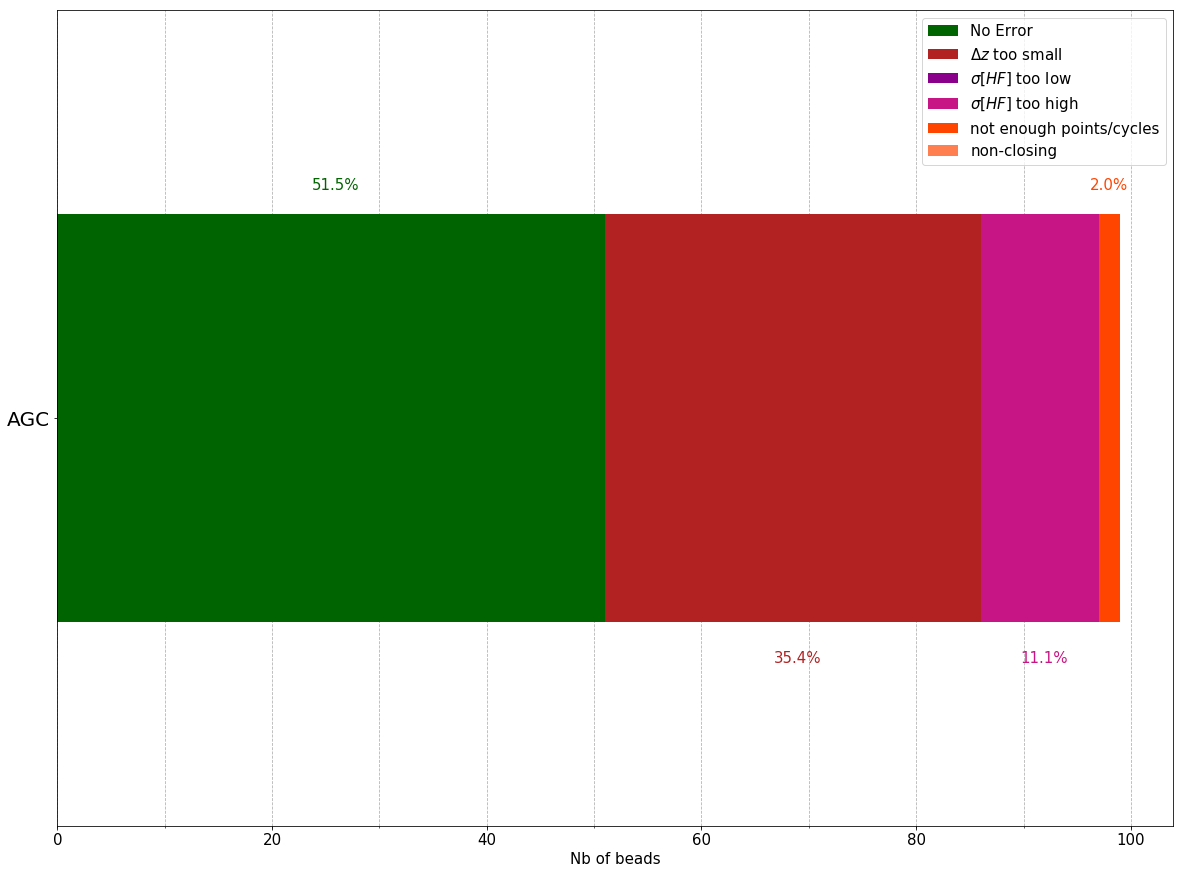

In [24]:
barBeadsByType(df_typeError_single,order_tracks_chrono_single)
plt.show()

## Barplot per Bead of Nb of Errors by type

We plot one bar chart per bead, where each column represents the number of errors (divided by type of error) registered for that bead in the corresponding track. 

In [25]:
#Create a dataframe fit to holoviews with nested categories. Columns are [bead track typeOfError nbErrors]
#one row correspond to one beads, in one specific track, that has nbErrors of the specific typeOfError
def dfCleaningMessages(tracks,orderbeads,ordertracks=None):
    try:
        tracks.keys()
        is_dict=True
    except AttributeError:
        is_dict = False
    
    dfmsg = tracks.cleaning.messages()

    #replace labels and names of columns
    dfmsg_reset = dfmsg.reset_index()
    dfmsg_reset = dfmsg_reset[['bead','key','message','cycles']] # ,'types','bead'
    dfmsg_reset.rename(columns={"bead":"bead","key": "track", "message": "typeOfError", "cycles":"NbErrors"},inplace=True)
    dfmsg_reset.replace('< 0.50','extent<0.5',inplace=True)
    dfmsg_reset.replace('< 80%' ,'pop<80%',inplace=True)
    dfmsg_reset.replace('< 0.0001','hfsigma<0.0001',inplace=True)
    dfmsg_reset.replace('> 0.0100','hfsigma>0.01',inplace=True)
    dfmsg_reset.replace('> 90%','sat>90%',inplace=True)

    ########## COMPLETE THE DF WITH 0's WHERE THERE IS NO INFORMATION ################
    ###HOW TO ADD ONE ROW TO DATAFRAME
    #df_test = pd.DataFrame([{'bead':0,'track':'GAG','typeOfError':'pop<80%','NbErrors':0}])
    #dfmsg_reset = dfmsg_reset.append(df_test)

    alltypes = {'extent<0.5','pop<80%','hfsigma<0.0001','hfsigma>0.01','sat>90%'}
    if is_dict:
        for bead in orderbeads:
            for trk in ordertracks:
                presenttypes = set(dfmsg_reset[(dfmsg_reset['bead']==int(bead)) & (dfmsg_reset['track']==trk)]['typeOfError'])
                missingtypes = alltypes - presenttypes
                if len(missingtypes)>0:
                    for adderror in missingtypes:
                        df_test = pd.DataFrame([{'bead':int(bead),'track':str(trk),'typeOfError':adderror,'NbErrors':0}])
                        dfmsg_reset = dfmsg_reset.append(df_test)
                        #print(df_test)
    else:
        for bead in orderbeads:
            presenttypes = set(dfmsg_reset[(dfmsg_reset['bead']==int(bead))]['typeOfError'])
            missingtypes = alltypes - presenttypes
            if len(missingtypes)>0:
                for adderror in missingtypes:
                    df_test = pd.DataFrame([{'bead':int(bead),'track':tracks.key,'typeOfError':adderror,'NbErrors':0}])
                    dfmsg_reset = dfmsg_reset.append(df_test)
                        #print(df_test)

    #    print(dfmsg_reset[(dfmsg_reset['bead']==bead) & (dfmsg_reset['track']==trk)])
    #for error in missingtypes:
    #    print(error)
    dfmsg_reset = dfmsg_reset.reset_index()
    
    if is_dict:
    #to sort from best to worst track
        dfmsg_reset.track = dfmsg_reset.track.astype("category")
        dfmsg_reset.track = dfmsg_reset.track.cat.set_categories(ordertracks,ordered=True)
        dfmsg_reset.sort_values(by='track',inplace=True) 
    
    #dfmsg_reset.sort_values(by=['bead'])[dfmsg_reset.sort_values(by=['bead'])['bead']==40].sort_values(by='track')
    return dfmsg_reset

In [26]:
dfmsg_single= dfCleaningMessages(track,order_beads_normal_single)

In [27]:
#Function barBeads that outputs a bar chart per bead, with columns tracks where the
#y-axis represents the number of errors (per type of error) for that bead 
#in the specific track
def barBeads(tracks,df_dfGoodBadBeads,dfmsg,ordertracks,orderbeads):
    try:
        tracks.keys()
        is_dict=True
    except AttributeError:
        is_dict = False

    %%output size = 300
    %%opts Bars [category_index=2 stack_index=0 group_index=1 legend_position='top' legend_cols=7 color_by=['stack'] tools=['hover']] 
    %%opts Bars.Stacked [stack_index='typeOfError'  ]  
   # %%opts Bars.Grouped [group_index='typeOfError'  ] 
   # %%opts Bars.Stacked (color=Cycle(values=["#B22222","#8B008B","#C71585", "#FF4500","#FF7F50"]))
#    %%
    %%opts Bars (color=Cycle(values=["#B22222","#8B008B","#C71585", "#FF4500","#FF7F50"]))
    %%opts Bars.Stacked (color=Cycle(values=["#B22222","#8B008B","#C71585", "#FF4500","#FF7F50"]))

    ordertracks = np.asarray(ordertracks)
    orderbeads = np.asarray(orderbeads)
    #orderbeads = list(orderbeads.astype(str))
    #title_format="tt"+badbead]
    ### HOLOVIEWS STACKED BAR ###
    # http://holoviews.org/reference/elements/bokeh/Bars.html

    #data_pc = df_dfGoodBadBeads[np.insert(ordertracks,0,'bead')]
    data_pc = df_dfGoodBadBeads.set_index('bead')
    goodpc = data_pc.astype('float').sum(axis=1)
    goodpc = goodpc.astype('float')
    N = len(ordertracks)

    def holo_bars(bead):
        copy = dfmsg
        copy = copy[copy['bead']==bead]
        copy = copy[['track','typeOfError','NbErrors']] 
        if is_dict:
            copy = copy.sort_values(['track','typeOfError'])
            #trackcount = N-goodpc.loc['{:.0f}'.format(bead)])
            mytitle = ("Bad Bead in {trackcount:.0f} out of {alltracks:.0f} ({pc:.1f} %)"
                        .format(trackcount = N-goodpc.loc['{:.0f}'.format(bead)],
                                alltracks = N,
                                pc = (N-goodpc.loc['{:.0f}'.format(bead)])/N*100)
                      )
                        
                      
            #mytitle= 'Bad Bead in '+ '{:.0f}'.format(N-goodpc.loc['{:.0f}'.format(bead)]) + ' out of '+ str(N) + '{:.0f}'.format(goodpc.loc['{:.0f}'.format(bead)]) #
            #mytitle ='Bad Bead in '+'{:.0f}'.format((N-goodpc.loc[bead]))+' out of '+str(N)+' tracks ('+str(round((N-goodpc.loc[bead])/N*100,1))+'%) -' 
           ##### to debug####  'nada '+ '{:.0f}'.format((N-goodpc.loc[bead])) # '{:.0f}'.format(N-goodpc.loc['{:.0f}'.format(bead)])#
        else:
            copy = copy.sort_values(['track','typeOfError'])
            mytitle= 'Bad bead -' if N-goodpc.loc[bead]!=0 else 'Good Bead -'
        if not is_dict:
            copytable = hv.Table(copy)
            barplot = copytable.to.bars(['typeOfError', 'track'], 'NbErrors', [],label=mytitle).redim.range(NbErrors=(0,200))
            #barplot = hv.Bars(copy,  ['track','typeOfError'], ['NbErrors'],group='Grouped',label=mytitle).redim.range(NbErrors=(0, 600)) #,group='Stacked'
            #barplot.relabel(group='Stacked')
        else:
            barplot = hv.Bars(copy,  ['track','typeOfError'], ['NbErrors'],group='Stacked',label=mytitle).redim.range(NbErrors=(0, 600)) #,group='Stacked'

        axes_opts = {'xrotation': 45}
        return barplot.opts(plot=axes_opts)#.relabel(group='Grouped')#*hv.Text(0, 400, 'Quadratic Curve')
        #return barplot

    dmap = hv.DynamicMap(holo_bars, kdims=['bead'])
    # dmap.redim.values(badbead = sorted(tracks.availablebeads())) #normal sort

    #TO DEBUG
    #hvbar_single = barBeads(track,df_dfGoodBadBeads[['bead','AGC']],dfmsg[dfmsg.track=='AGC'],order_tracks_chrono_single,order_beads_normal_single)
    #hvbar_single
    mybeads = [float(i) for i in orderbeads]
    return dmap.redim.values(bead = mybeads).redim(NbErrors = "Count") #sorted by badfirst


In [28]:
hvbar_single = barBeads(track,df_dfGoodBadBeads_single,dfmsg_single,order_tracks_chrono_single,order_beads_normal_single)
hvbar_single

/home/sandra/miniconda3/lib/python3.6/site-packages/bokeh/models/sources.py:137: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('Count', 5), ('bottom', 5), ('top', 5), ('typeOfError', 15)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


:DynamicMap   [bead]

# Analysis for a dictionary of tracks

## Number of Good Beads per Track

We plot a heatmap of good beads per track.

In [29]:
#Function heatmapNumGoodBeads that outputs a seaborn heatmap with the number of good beads per track
def heatmapNumGoodBeads(df_resumeTracksQuality,pc,order = 'chrono'):
    """(pandas dataframe, bool, str) -> Seaborn heatmap
    This function receives a dataframe output by the function 
    resumeTracksQuality a boolean True if we want porcentages and false
    if we want the number of beads and a string representing the order
    of the beads ('chrono' -by default- or 'best_to_worst'). 
    The output is a seaborn heatmap with one column representing 
    the number (or percentage) of good beads and each line representing a track
    """
    
    import seaborn as sns; sns.set()
    total_beads = len(tracks.availablebeads())

    if pc:
        df_resumeTracksQuality[['Good','Bad','Total']] = df_resumeTracksQuality[['Good','Bad','Total']].divide(df_resumeTracksQuality['Total'],axis='index')
        df_resumeTracksQuality[['Good','Bad','Total']] = round(df_resumeTracksQuality[['Good','Bad','Total']]*100,2)

   #order = 'chrono' #'chrono' or 'best_to_worst'
    if order == 'chrono':
        df_resumeTracksQuality = df_resumeTracksQuality.reset_index()
        df_resumeTracksQuality.Track = df_resumeTracksQuality.Track.astype('category')
        df_resumeTracksQuality.Track.cat.set_categories(order_tracks_chrono,inplace=True)
        df_resumeTracksQuality = df_resumeTracksQuality.sort_values(['Track'])
        df_resumeTracksQuality.set_index('Track',inplace=True) 
    elif order == 'best_to_worst':
        df_resumeTracksQuality = df_resumeTracksQuality.sort_values(['Good'],ascending = False)

    ax = sns.heatmap(df_resumeTracksQuality[['Good']],
                     annot = True,
                     fmt = ".1f" if pc else ".0f",
                     cmap = 'BuGn',
                     vmin = 0,
                     vmax = 100 if pc else total_beads,
                     xticklabels = False,
                     annot_kws = {'size':11},
                     square = True,
                     linewidths = 0.5)
    ax.figure.set_size_inches(6,12)
    if pc:
        plt.title('% of Good Beads (Total {:.0f} beads)'.format(total_beads))
    else:
        plt.title('# Good Beads (Total {:.0f} beads)'.format(total_beads))

    plt.ylabel('Tracks ('+['chronological' if order=='chrono' else 'best-to-worst'][0]+' order)')
    return ax


In [30]:
#heatmapNumGoodBeads(resume,pc=True,order='chrono')
#pc = True for percentages, False for #
#order = 'chrono' for chronological order of the tracks, 'best_to_worst' to sort by #good beads
#plt.show()

## Percentage of Good/Bad (detailed) Beads per Track

We plot a more detailed heatmap considering also the bad beads and their most common error (between the errors defined in the criteria of `cleaning`).

In [31]:
df_resumeBeadsQuality = resumeBeadsQuality(tracks,order_tracks_chrono)


In [39]:
#Function heatmapBeadsByType that outputs seaborn heatmap with the number of good beads per track, and bad goods by type of error
def heatmapBeadsByType(df_resume,pc=True,order = 'chrono'):
    import seaborn as sns
    df_discarded_beads = None
    df_discarded_beads = df_resume.copy()
    df_discarded_beads = df_discarded_beads[['bead','track',
                                         'extent<0.5','hfsigma<0.0001',
                                        'hfsigma>0.01','sat>90%','pop<80%']]
    df_discarded_beads = df_discarded_beads.assign(mostCommonError = df_discarded_beads.set_index(['bead','track']).idxmax(axis=1).values)
    df_discarded_beads = df_discarded_beads.assign(mostCommonError = np.where(df_discarded_beads.set_index(['bead','track']).max(axis=1)==0,
                                                                         'noError',
                                                                         df_discarded_beads['mostCommonError']))
    if pc:
        data_discarded = pd.crosstab(df_discarded_beads['track'],
                                     df_discarded_beads['mostCommonError'],
                                     normalize='index')*100
    else:
        data_discarded = pd.crosstab(df_discarded_beads['track'],
                                     df_discarded_beads['mostCommonError'])

    #data_discarded = data_discarded.sort_values(['noError'],ascending=False)
    if order=='chrono':
        data_discarded = data_discarded.loc[order_tracks_chrono]
    elif order == 'best_to_worst':
        data_discarded = data_discarded.sort_values(['noError'],ascending=False)

    fig, ax =plt.subplots(ncols=2)
    fig.set_size_inches(10, 12)
    myfmt = '.1f' if pc else '.0f'
    prefix_title = '%' if pc else '#'
    noError_beads = sns.heatmap(data_discarded[['noError']],
                            annot=True,
                            fmt=myfmt,
                            cmap='Greens',
                            vmin = 0,
                            vmax = 100,
                            linewidths=0.5,
                            ax=ax[0],
                            square=True)
    noError_beads.set_yticklabels(noError_beads.get_yticklabels(),rotation=0)
    noError_beads.set_xticklabels(noError_beads.get_xticklabels(),rotation=30)
    total_beads = len(tracks.availablebeads())
    ax[0].set_title(prefix_title+' of Beads with no Errors (Total {:.0f} beads)'.format(total_beads))
    ax[0].set_xlabel('')
    ax[0].set_ylabel('Tracks ('+['chronological' if order=='chrono' else 'best-to-worst'][0]+' order)')
#    mylegend = plt.legend()
#    mylegend.get_texts()[0].set_text('No Error')
#    mylegend.get_texts()[1].set_text(r'$\Delta z$ too small')
#    mylegend.get_texts()[2].set_text(r'$\sigma[HF]$ too low')
#    mylegend.get_texts()[3].set_text(r'$\sigma[HF]$ too high')
#    mylegend.get_texts()[4].set_text(r'not enough points/cycles')
#    mylegend.get_texts()[5].set_text(r'non-closing')
    data_discarded.pop('noError')
    error_beads = sns.heatmap(data_discarded,
                          annot=True,
                          fmt=myfmt,
                          vmin = 0,
                          vmax = 100,
                          cmap='Reds',
                          linewidths=0.5,
                          ax=ax[1])
    error_beads.set_xticklabels(error_beads.get_xticklabels(),rotation=30)
    error_beads.set_yticklabels(error_beads.get_yticklabels(),rotation=0)

    ax[1].set_title(prefix_title+' of Beads by most common error (Total {:.0f} beads)'.format(total_beads))
    ax[1].set_xlabel('')
    ax[1].set_ylabel('Tracks ('+['chronological' if order=='chrono' else 'best-to-worst'][0]+' order)')
    plt.tight_layout()
    return ax


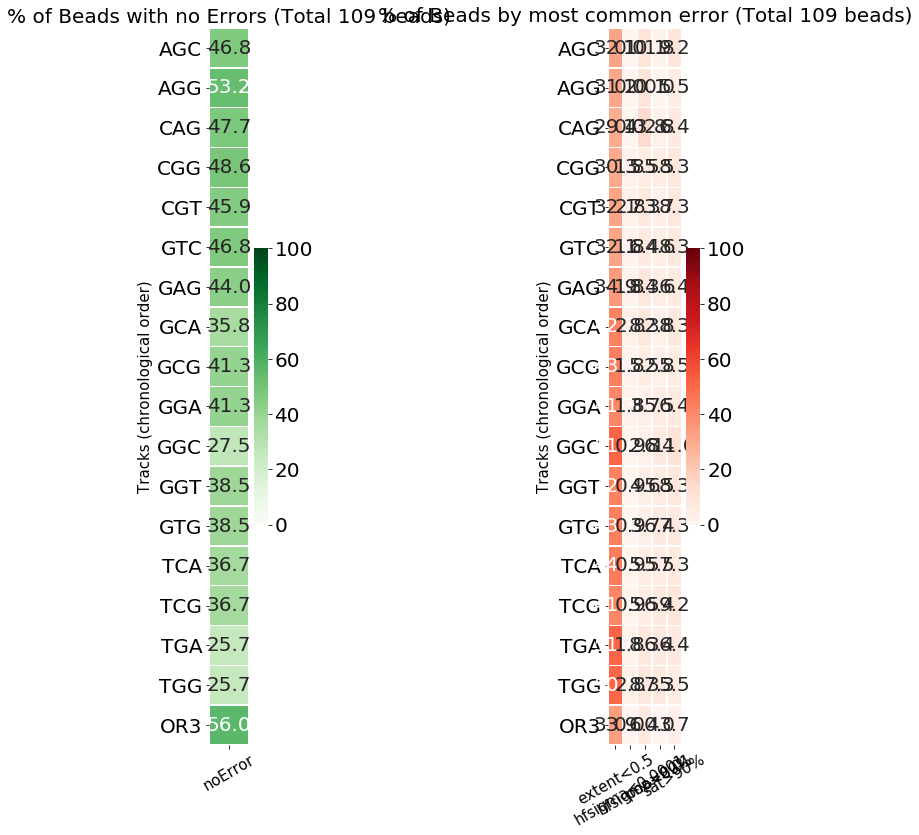

In [40]:
heatmapBeadsByType(df_resumeBeadsQuality,pc=True,order='chrono') #pc = True for percentages, False for # // order = 'chrono' or 'best_to_worst'
plt.show()

## Distribution of Good/Beads per Track

We plot a matrix of beads and tracks. Each cell $(i,j)$ is a dychotomous variable: $1$ if the bead $i$ is good in track $j$ and $0$ if the bead is considered bad in track $j$. The plot present the good beads in green and the bad beads in red.

In [30]:
#Function heatmapGoodBad that outputs bokeh heatmap with the status the beads per track (Good or Bad beads)
def heatmapGoodBad(data,order = 'chrono'):
    from math import pi
    import pandas as pd

    from bokeh.io import show
    from bokeh.models import (
        ColumnDataSource,
        HoverTool,
        LinearColorMapper,
        BasicTicker,
        PrintfTickFormatter,
        ColorBar,
    )
    from bokeh.plotting import figure
    
    data['bead'] = data['bead'].astype(str)
    data = data.set_index('bead')
    data.columns.name = 'track'
    data=data.transpose()

    plotbeads = list(data.columns)
    if order=='chrono':
        plottracks = order_tracks_chrono #list(data.index) #this is order_tracks_chrono if we used that as the order before, otherwise it is best to worst
    elif order == 'best_to_worst':
        plottracks = list(data.index)
        
    # reshape to 1D array 
    df = pd.DataFrame(data.stack(), columns=['quality']).reset_index()
    
    # colormap
    colors = [ "#8B0000","#006400"] #[ "#550b1d","#75968f"] #
    mapper = LinearColorMapper(palette=colors, low=df.quality.min(), high=df.quality.max())
    source = ColumnDataSource(df)

    TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

    p = figure(title="Bead's quality",
           x_range=plottracks, y_range=plotbeads,
           x_axis_location="above", plot_width=1000, plot_height=1500,
           tools=TOOLS, toolbar_location='below')
    
    p.grid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "10pt"
    p.axis.major_label_standoff = 5
    p.axis.axis_label_standoff = 10
    p.xaxis.major_label_orientation = pi / 3

    p.rect(x="track", y="bead", width=1, height=1,
       source=source,
       fill_color={'field': 'quality', 'transform': mapper},
       line_color=None)
    
    color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="9pt",
                     ticker=BasicTicker(desired_num_ticks=len(colors)),
                     formatter=PrintfTickFormatter(format="%s"),
                     label_standoff=10, border_line_color=None, location=(1, 0),
                     major_label_overrides={0:'Bad Beads',0.5:'',1:'Good Beads'},
                    major_tick_out=20)
    
    p.add_layout(color_bar, 'right')

    p.select_one(HoverTool).tooltips = [
     ('Bead/Track', '@bead @track'),
     ('Quality', '@quality'),
    ]
    return p

In [31]:
p = heatmapGoodBad(df_dfGoodBadBeads,order = 'chrono')
from bokeh.io import show
show(p)

## Distribution of Good/Bad Beads (detailed)  per Track

We plot the previous matrix with more detail, using the information of the most common error per bead. Each cell is a nominal variable:
* $0$ if the bead is good
* $1$ if the bead's most common error is `extent < 0.5`
* $2$ if the bead's most common error is `hfsigma < 0.0001`
* $3$ if the bead's most common error is `hfsigma > 0.01`
* $4$ if the bead's most common error is `pop < 80%`
* $5$ if the bead's most common error is `sat > 90%`


In [42]:
#Function heatmapGoodBadDetailed that outputs bokeh heatmap with the status the beads per track, bad beads by most Common Error
def heatmapGoodBadDetailed(df_state_beads,order_beads = order_beads_best, order = 'chrono'):
    from math import pi
    import pandas as pd

    #from bokeh.io import show
    from bokeh.models import (
        ColumnDataSource,
        HoverTool,
        LinearColorMapper,
        BasicTicker,
        PrintfTickFormatter,
        ColorBar,
    )
    from bokeh.plotting import figure, show
    
    order_beads = np.asarray(order_beads)
    df_state_beads = df_state_beads.assign(mostCommonError =df_state_beads.set_index(['bead','track']).idxmax(axis=1).values)
    df_state_beads = df_state_beads.assign(mostCommonError = np.where(df_state_beads.set_index(['bead','track']).max(axis=1)==0,
                                                                         'noError',
                                                                         df_state_beads['mostCommonError']))
    df_state_beads = df_state_beads[['bead','track', 'mostCommonError']]
    
    plotbeads = order_beads # df_state_beads['bead'].unique()
    plottracks = order_tracks_chrono if order=='chrono' else order_tracks_best
    aux = pd.DataFrame('', index=plottracks, columns=plotbeads)

    for bd in plotbeads:
        for trk in plottracks:
            aux.loc[trk][bd] = df_state_beads[(df_state_beads['bead']==bd) & (df_state_beads['track']==trk)].mostCommonError.values[0]
    
    # reshape to 1D array 
    df = pd.DataFrame(aux.stack(), columns=['typeError']).reset_index()

    df['typeError'] = np.where(df['typeError']=='noError',int(0),df['typeError'])
    df['typeError'] = np.where(df['typeError']=='extent<0.5',int(1),df['typeError'])
    df['typeError'] = np.where(df['typeError']=='hfsigma<0.0001',int(2),df['typeError'])
    df['typeError'] = np.where(df['typeError']=='hfsigma>0.01',int(3),df['typeError'])
    df['typeError'] = np.where(df['typeError']=='pop<80%',int(4),df['typeError'])
    df['typeError'] = np.where(df['typeError']=='sat>90%',int(5),df['typeError'])

    df.columns = ['track','bead','typeError']
    df['typeError'] = df['typeError'].apply(pd.to_numeric,errors='coerce') 
    #print(df)
    
    # colormap
    colors = [ "#006400","#B22222","#8B008B","#C71585", "#FF4500","#FF7F50"] #

    mapper = LinearColorMapper(palette=colors, low=df.typeError.min(), high=df.typeError.max())

    #source = ColumnDataSource(df)
    source=df
    df['bead'] = df['bead'].astype(str)
    
    TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"
    
    plotbeads = plotbeads.astype(str) #change to string for the figure
    
    
    p = figure(plot_width=1000, plot_height=1500,title="Bead's Status",
                   x_range=plottracks, y_range=plotbeads,
                   x_axis_location="above",
                   tools=TOOLS, toolbar_location='below')
    
    p.grid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "12pt"
    p.axis.major_label_standoff = 5
    p.axis.axis_label_standoff = 10
    p.xaxis.major_label_orientation = pi / 3
    
    
    p.rect(x="track", y="bead", width=1, height=1, source=df,
                   fill_color={'field': 'typeError', 'transform': mapper},
                   line_color=None)
    

    color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="13pt",
                     ticker=BasicTicker(desired_num_ticks=len(colors)),
                     formatter=PrintfTickFormatter(format="%s"),
                     label_standoff=20, border_line_color=None, location=(1, 0),
                     major_label_overrides={0:'noError',
                                            1:'extent<0.5',
                                            2:'hfsigma<0.0001',
                                            3:'hfsigma>0.01',
                                            4:'pop<80%',
                                            5:'sat<90%'}, major_tick_out=20)
    p.add_layout(color_bar, 'right')

    p.select_one(HoverTool).tooltips = [
     ('Bead/Track', '@bead @track'),
     ('Type of Error', '@typeError'),
    ]
    return p

In [43]:
plot = heatmapGoodBadDetailed(df_resumeBeadsQuality,order = 'chrono')
show(plot)

## Flow diagram of Beads from first to last Track

We plot a flow diagram between two tracks. By default, we take the first and last track to observe the proportion of beads that changed from status `good` to error by `extent`. We can also specify the first and last track to see the flow between them.

In [33]:
df_typeError = typeError(df_resumeBeadsQuality,order_beads_best,order_tracks_chrono)


In [34]:
#Function flowBeads that outputs a flow diagram between two tracks showing the proportion
#of the beads classified by their status (their mostCommonError)
def flowBeads(df_sankey,first_track = None,last_track=None):
    import sankey
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    pd.options.display.max_rows=8
    %matplotlib inline

    #https://github.com/anazalea/pySankey
    #test_sankey = aux.set_index('index')
    if first_track==None:
        first_track = df_sankey.columns[0]
    if last_track==None:
        last_track = df_sankey.columns[-1]
        
    df_sankey = df_sankey[[first_track, last_track]]

    #colors3 = [ "#006400","#B22222","#8B008B","#C71585", "#FF4500","#FF7F50"] #

    colorDict =  {'noError':'#006400','extent<0.5':'#B22222','hfsigma<0.0001':'#8B008B','hfsigma>0.01':'#C71585','sat>90%':'#FF4500', 'pop<80%':'#FF7F50'  }

    df_sankey.reset_index()
    df_sankey = df_sankey.reset_index()[[first_track,last_track]]
    df_sankey
    sankey.sankey(df_sankey[first_track],df_sankey[last_track],
              aspect=20,
              colorDict=colorDict,
              fontsize=12,
              leftLabels=['pop<80%','sat>90%', 'hfsigma>0.01', 'hfsigma<0.0001', 'extent<0.5', 'noError'],
              rightLabels=['pop<80%','sat>90%', 'hfsigma>0.01', 'hfsigma<0.0001', 'extent<0.5', 'noError'])
    plt.gcf().set_size_inches(12,12)
    plt.title('Track '+first_track+ r'$\longrightarrow$ Track '+last_track)
    #plt.savefig('sankey.png',bbox_inches='tight',dpi=150)
    return plt


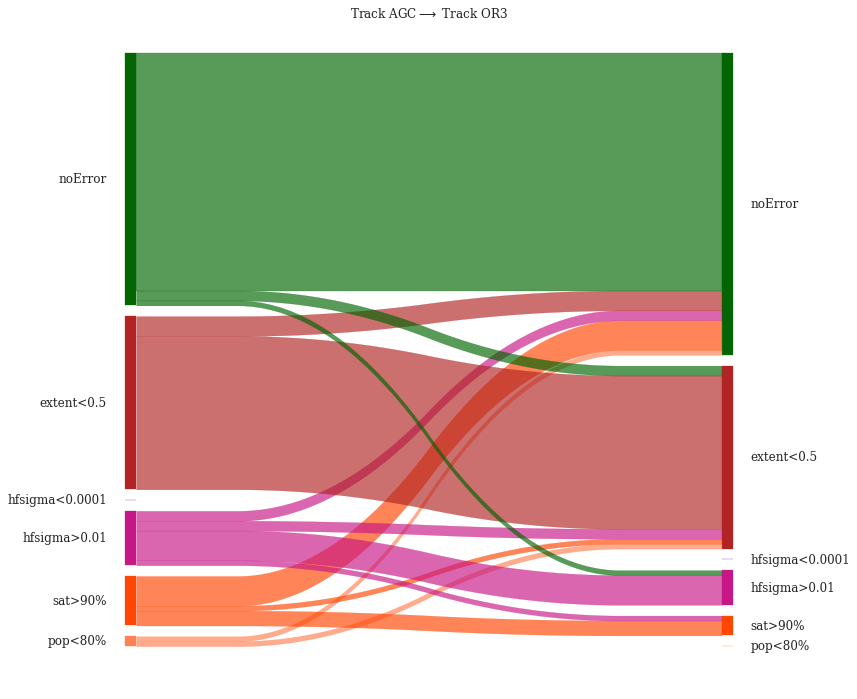

In [35]:
flow_diagram = flowBeads(df_typeError,first_track=None, last_track=None)
flow_diagram.show()

## Barplot per Bead of Nb of Errors for each track

We plot one bar chart per bead, where each column represents the number of errors (divided by type of error) registered for that bead in the corresponding track. 

In [46]:
dfmsg = dfCleaningMessages(tracks,order_beads_normal,order_tracks_chrono)

In [51]:
hvbar = barBeads(tracks,df_dfGoodBadBeads,dfmsg,order_tracks_chrono,order_beads_best)
hvbar

:DynamicMap   [bead]

In [38]:
################## OLD VERSION ###########################################
#Function barBeads that outputs a bar chart per bead, with columns tracks where the
#y-axis represents the number of errors (per type of error) for that bead 
#in the specific track
def barBeads2(tracks,df_dfGoodBadBeads,dfmsg,ordertracks,orderbeads):
    try:
        tracks.keys()
        is_dict=True
    except AttributeError:
        is_dict = False
    
    print(is_dict)
    %%output size = 200
    %%opts Bars.Stacked [stack_index='typeOfError'  ]  
    %%opts Bars.Grouped [group_index='typeOfError'  ] 
    %%opts Bars.Stacked (color=Cycle(values=["#B22222","#8B008B","#C71585", "#FF4500","#FF7F50"]))
#    %%
#    %%opts Bars.Grouped (color=Cycle(values=["#B22222","#8B008B","#C71585", "#FF4500","#FF7F50"]))
    
    #orderbeads = list(orderbeads.astype(str))
    #title_format="tt"+badbead]
    ### HOLOVIEWS STACKED BAR ###
    # http://holoviews.org/reference/elements/bokeh/Bars.html

    #data_pc = df_dfGoodBadBeads[np.insert(ordertracks,0,'bead')]
    data_pc = df_dfGoodBadBeads.set_index('bead')
    goodpc = data_pc.astype('float').sum(axis=1)
    goodpc = goodpc.astype('float')
    N = len(ordertracks)

    def holo_bars(bead):
        copy = dfmsg
        copy = copy[copy['bead']==bead]
        copy = copy[['track','typeOfError','NbErrors']] # ,'types','bead'
        if is_dict:
            copy = copy.sort_values(['track','typeOfError'])
        else:
            copy = copy.sort_values(['track','typeOfError'])
        mytitle= 'Bad in '+'{:.0f}'.format((N-goodpc.loc[bead]))+' out of '+str(N)+' tracks ('+str(round((N-goodpc.loc[bead])/N*100,1))+'%) -'  #'{:.0f}'.format(bead)
       # copy = [tuple(x) for x in copy.values]
        print(copy)
        if is_dict:
            barplot = hv.Bars(copy,  ['track','typeOfError'], ['NbErrors'],group='Stacked',label=mytitle).redim.range(NbErrors=(0, 600)) #,group='Stacked'
            #barplot.relabel(group='Stacked')
        #else:
        #    barplot = hv.Bars(copy,  kdims = ['track','typeOfError'], vdims = ['NbErrors'],label=mytitle).redim.range(NbErrors=(0, 1.1*len(orderbeads))) #,group='Grouped'
        #    barplot.relabel(group='Grouped')

        axes_opts = {'xrotation': 45}
        return barplot.opts(plot=axes_opts)#.relabel(group='Grouped')#*hv.Text(0, 400, 'Quadratic Curve')
        #return barplot

    dmap = hv.DynamicMap(holo_bars, kdims=['bead'])

    mybeads = [float(i) for i in orderbeads]
    return dmap.redim.values(bead = mybeads) #sorted by badfirst
    # dmap.redim.values(badbead = sorted(tracks.availablebeads())) #normal sort

################ OLD VERSION ###################################################"